In [340]:
import sys
import os

file_path = os.getcwd()
parent_dir = os.path.split(file_path)[0]
sys.path.insert(0, parent_dir + "/hpt/")
sys.path.insert(0, parent_dir + "/knockpy/")
import hpt

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

import knockpy

In [133]:
def calc_mean_sem(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_se'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_se']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_se']
    
    return agg_df.loc[:, agg_df.columns.get_level_values(1) == '']

## 1.2 Example plots

### 1.2.1 Changepoint example

In [19]:
# Generate data
np.random.seed(123) # original good one
T = 100
delta = 0.75 # original: 1.75
X = np.arange(T)
Y = np.random.randn(T)
Y[int(T/2):] += delta
mu = np.zeros(T)
mu[int(T/2):] += delta

In [15]:
# # Plot #1
# df = pd.DataFrame()
# df['X'] = X
# df['Y'] = Y
# fig, ax = plt.subplots(figsize=(3,2))
# ax = sns.regplot(
#     ax=ax,
#     data=df, 
#     x='X', 
#     y='Y', 
#     color='#6495ED',
#     label='Y',
#     line_kws={'color':'seagreen'},
# )
# #ax = lmplot.axes[0, 0]
# ax.plot(X[0:int(T/2)], mu[0:int(T/2)],
#     color='red',
#     label='True mean',
#     linestyle='dashed'
# )
# ax.plot(X[int(T/2):], mu[int(T/2):],
#     color='red',
#     linestyle='dashed'
# )
# ax.set(xlabel='t', ylabel='Y')
# ax.legend()
# #plt.savefig("final-plots/changepoint_example.png", dpi=500)

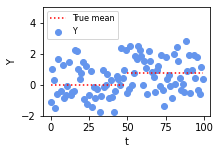

In [35]:
# Plot #2
fig, ax = plt.subplots(figsize=(3,2))
ax.scatter(X, Y, label='Y', color='#6495ED')
ax.plot(X[0:int(T/2)], mu[0:int(T/2)],
    color='red',
    label='True mean',
    linestyle='dotted'
)
ax.plot(X[int(T/2):], mu[int(T/2):],
    color='red',
    linestyle='dotted'
)
ax.set(ylabel='Y', xlabel='t')
ax.set_ylim(-2, 5)
ax.legend(loc=(2), prop={'size': 8})
#plt.show()
plt.savefig("final-plots/changepoint_example.png", dpi=500)

### 1.2.2 Astro Example

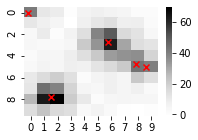

In [258]:
import scipy.signal 

# Create x, y
p = 10
z = np.zeros((p, p))
x = np.arange(p).reshape(-1, 1)
x = np.repeat(x, p, axis=1)
y = x.T

# Create point sources
np.random.seed(110)
# k = 15
# xsource = 10*np.random.uniform(size=(k,))
# ysource = 10*np.random.uniform(size=(k,))
# magsource = 20 + np.abs(10*np.random.randn(k))


xsource = [0.5, 8.25, 5.234, 5.5398, 3.234097]
ysource = [0.25, 2, 8.357098, 9.12309, 6.2509]
magsource = [50, 100, 35, 25, 83]

# Create means 
mu = z.copy()
for (i, j, mag) in zip(xsource, ysource, magsource):
    d = np.sqrt(np.power(i-x-0.5, 2) + np.power(j-y-0.5,2))
    mu += mag * np.exp(-1*d)


# Create data
D = np.sqrt(mu) * np.random.randn(p, p) + mu #3*np.random.randn(p, p) + mu

# Plot
fig, ax = plt.subplots(figsize=(3,2))
ax = sns.heatmap(D, cmap='Greys', ax=ax)
ax.scatter(ysource, xsource, color='red', marker='x', label='True Sources')
#ax.legend(bbox_to_anchor=(1.1, 1.3))
plt.savefig("final-plots/astro_example.png", dpi=500)

### 1.2.3 Noncentral F-test

In [222]:
def H_mat(X):
    inv = np.linalg.inv(np.dot(X.T, X))
    return np.dot(X, np.dot(inv, X.T))

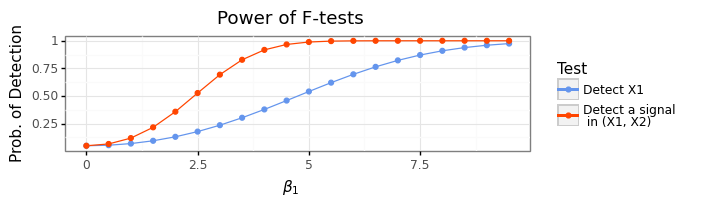

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 1.5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/examples/ftest_example.png


In [338]:
import numpy as np
import pandas as pd
from scipy import stats

# Columns for data-matrix
columns = ['beta1', 'Detect X1', 'Detect a signal \n in (X1, X2)']
output = []

# Parameters
alpha = 0.05
rho = 0.9

# Thresholds
t1 = stats.f(dfn=1, dfd=n-2).ppf(1-alpha)
t2 = stats.f(dfn=2, dfd=n-2).ppf(1-alpha)

# Power of tests for various beta
betas = np.arange(20) / 2
mu1 = (1 - rho**2) * np.power(betas, 2)
mu2 = np.power(betas, 2)
power1 = 1 - stats.ncf(nc=mu1, dfn=1, dfd=n-2).cdf(t1)
power2 = 1 - stats.ncf(nc=mu2, dfn=2, dfd=n-2).cdf(t2)

# Put into dataframe and plot
df = pd.DataFrame(columns=columns)
df['beta1'] = betas
df[columns[1]] = power1
df[columns[2]] = power2
df = pd.melt(df, id_vars='beta1', value_name='Power', var_name='Test')
g = (
    ggplot(
        df, 
        aes(x='beta1', y='Power', color='Test')
    )
    + geom_line()
    + geom_point()
    + theme_bw()
    + theme(figure_size=(6,1.5))
    + labs(
        title='Power of F-tests', 
        x=r'$\beta_1$',
        y='Prob. of Detection'
    )
    + scale_color_manual(['cornflowerblue', 'orangered'])
)
print(g)
g.save("final-plots/examples/ftest_example.png", dpi=500)

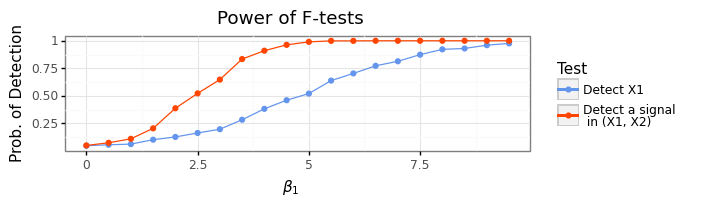

In [339]:
#### For testing, we also simulate the power curves.
#### This plot is not published since it's just
#### a sanity check :)

n = 20
cov = np.array([[1, rho], [rho, 1]])
L = np.linalg.cholesky(cov)

# Generate X s.t. XTX = cov
X = np.dot(L, np.random.randn(2, n-2)).T / np.sqrt(5*(n-2))
cov_left = cov - np.dot(X.T, X)
L_left = np.linalg.cholesky(cov_left)
X = np.concatenate([X, L_left.T], axis=0)

# Invert
XTXinv = np.linalg.inv(np.dot(X.T, X))

# For f-tests
H = H_mat(X)
H2 = H_mat(X[:, [1]])

# Generate y | X
for beta1 in betas:
    for j in range(1000):
        y = X[:, 0] * beta1 + np.random.randn(n)

        # F-test testing beta1, beta2 = 0
        denom = np.dot(y, np.dot(np.eye(n) - H, y)) / (n - 2)
        T1 = np.dot(y, np.dot(H - H2, y)) / denom
        T2 = np.dot(y, np.dot(H, y)) / 2 / denom

        # append
        output.append([beta1, T1 > t1, T2 > t2])

df = pd.DataFrame(output, columns=columns)
df = pd.melt(df, id_vars=['beta1'], value_name='Power', var_name='Test')
agg = calc_mean_sem(
    df, 
    group_vals=['beta1', 'Test'], 
    meas=['Power']
)
g = (
    ggplot(
        agg, 
        aes(x='beta1', y='Power_mean', color='Test')
    )
    + geom_line()
    + geom_point()
    + theme_bw()
    + theme(figure_size=(6,1.5))
    + labs(
        title='Power of F-tests', 
        x=r'$\beta_1$',
        y='Prob. of Detection'
    )
    + scale_color_manual(['cornflowerblue', 'orangered'])
)
print(g)

## 2.3 Integer-relaxation plots

In [24]:
import numpy as np
import pandas as pd
from plotnine import *

day = '2021-11-09'
t = '04-54-55' 

data = pd.read_csv(f"data/lp_int_sol/{day}/{t}/results.csv")

In [25]:
id_vars = ['kappa', 'p', 'sparsity', 'covmethod']
#cov_dict = {'ar1':'AR1', 'ver':'ErdosRenyi (Cov.)', 'qer':'ErdosRenyi (Prec.)'}
cov_dict = {'ar1':'AR1', 'ver':'VER', 'qer':'QER'}

### Averages of number of randomized pairs/singletons

In [26]:
var_dict = {
    'n_singleton':'Other non-integers', 'n_rand_pairs':'Randomized pairs'
}
mdata = pd.melt(
    data[id_vars + ['n_rand_pairs', 'n_singleton']],
    id_vars=id_vars,
    var_name='variable',
    value_name='value'
)
mdata['variable'] = mdata['variable'].map(var_dict)
agg_df = calc_mean_sem(mdata, group_vals=id_vars + ['variable'], meas=['value'])
agg_df['covmethod'] = agg_df['covmethod'].map(cov_dict)
agg_df.head()

,kappa,p,sparsity,covmethod,variable,value_mean,value_se,value_ymin,value_ymax
,,,,,,,,,
0,0.05,1000,0.05,AR1,Other non-integers,1.921875,0.461832,0.998212,2.845538
1,0.05,1000,0.05,AR1,Randomized pairs,2.320312,0.415013,1.490286,3.150339
2,0.05,1000,0.05,QER,Other non-integers,1.679688,0.560438,0.558811,2.800564
3,0.05,1000,0.05,QER,Randomized pairs,2.851562,0.350248,2.151067,3.552058
4,0.05,1000,0.05,VER,Other non-integers,1.265625,0.376553,0.512520,2.018730


/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 1 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section2/randomization_counts.png


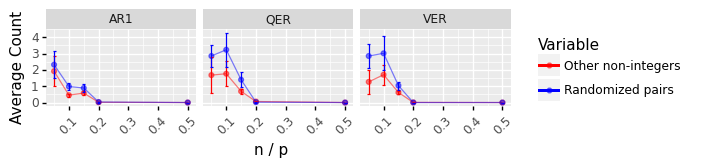

In [27]:
g = (
    ggplot(
        agg_df, aes(x='kappa', y='value_mean', color='variable')
    )
    + geom_point(alpha=0.5)
    + geom_line(alpha=0.5)
    + geom_errorbar(aes(ymin="value_ymin", ymax="value_ymax"), width=0.01)
    + facet_wrap("~covmethod")
    + labs(x=r'n / p', y='Average Count', color='Variable')
    + theme(
        figure_size=(6,1),
        axis_text_x=element_text(angle=45)
    )
    + scale_color_manual(['red', 'blue'])

)
g.save("final-plots/section2/randomization_counts.png", dpi=500)
print(g)

### Averages of objective function

In [28]:
data['epower_ilp_diff'] = (data['epower_ilp']  - data['epower_lp']) 
data['epower_sample_diff'] =  (data['epower_sample'] - data['epower_lp'])
meas_dict = {
    #'epower_lp':'Relaxed LP',
    'epower_ilp_diff':'BLiP (deterministic)',
    'epower_sample_diff':'BLiP (randomized)'
}
meas = list(meas_dict.keys())
# melt
mdata = pd.melt(
    data[id_vars + meas],
    id_vars=id_vars,
    var_name='measurement',
    value_name='value'
)

agg_df = calc_mean_sem(
    mdata,
    group_vals=id_vars + ['measurement'], 
    meas=['value'],
    trunc_zero=False
)
agg_df['measurement'] = agg_df['measurement'].map(meas_dict)
agg_df['covmethod'] = agg_df['covmethod'].map(cov_dict)
agg_df.head()

,kappa,p,sparsity,covmethod,measurement,value_mean,value_se,value_ymin,value_ymax
,,,,,,,,,
0,0.05,1000,0.05,AR1,BLiP (deterministic),-0.049741,0.005353,-0.060447,-0.039035
1,0.05,1000,0.05,AR1,BLiP (randomized),-0.002921,0.008497,-0.019914,0.014073
2,0.05,1000,0.05,QER,BLiP (deterministic),-0.019205,0.001997,-0.023200,-0.015211
3,0.05,1000,0.05,QER,BLiP (randomized),-0.011434,0.009428,-0.030290,0.007421
4,0.05,1000,0.05,VER,BLiP (deterministic),-0.027239,0.003951,-0.035142,-0.019336


/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 1 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: final-plots/section2/objective_gap.png


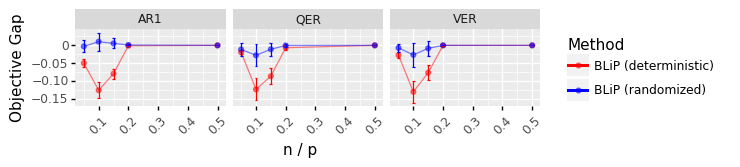

In [29]:
g = (
    ggplot(
        agg_df, aes(x='kappa', y='value_mean', color='measurement')
    )
    + geom_point(alpha=0.5)
    + geom_line(alpha=0.5)
    + geom_errorbar(aes(ymin="value_ymin", ymax="value_ymax"), width=0.01)
    + facet_wrap("~covmethod")
    + labs(x=r'n / p', y='Objective Gap', color='Method')
    + theme(
        figure_size=(6,1),
        axis_text_x=element_text(angle=45)
    )
    + scale_color_manual(['red', 'blue'])
)
g.save("final-plots/section2/objective_gap.png", dpi=500)
print(g)

### Trying to show distribution, this is trickier

In [21]:
#['kappa', 'p', 'sparsity', 'covmethod']
id_vars = [
    c for c in data.columns if c not in ['n_singleton', 'n_rand_pairs']
]
ndata = data.melt(
    id_vars=id_vars,
    value_name='num_nonzero'
)
# ndata['num_nonzero'] = ndata['num_nonzero'].astype(
#     pd.api.types.CategoricalDtype(categories=ndata['num_nonzero'].unique())
# )
ndata['variable'] = ndata['variable'].map(var_dict)
cdata = ndata.groupby(
    ['kappa', 'p', 'sparsity', 'covmethod', 'variable', 'num_nonzero']
)['seed'].count().reset_index()
cdata['seed'] = data['seed'] / np.unique(data['seed'].values).shape[0]
cdata = cdata.rename(columns=dict(seed='proportion'))
cdata.head()

,kappa,p,sparsity,covmethod,variable,num_nonzero,proportion
0,0.05,1000,0.05,ar1,Randomized pairs,0,0.007812
1,0.05,1000,0.05,ar1,Randomized pairs,1,0.015625
2,0.05,1000,0.05,ar1,Randomized pairs,2,0.023438
3,0.05,1000,0.05,ar1,Randomized pairs,3,0.031250
4,0.05,1000,0.05,ar1,Randomized pairs,4,0.039062


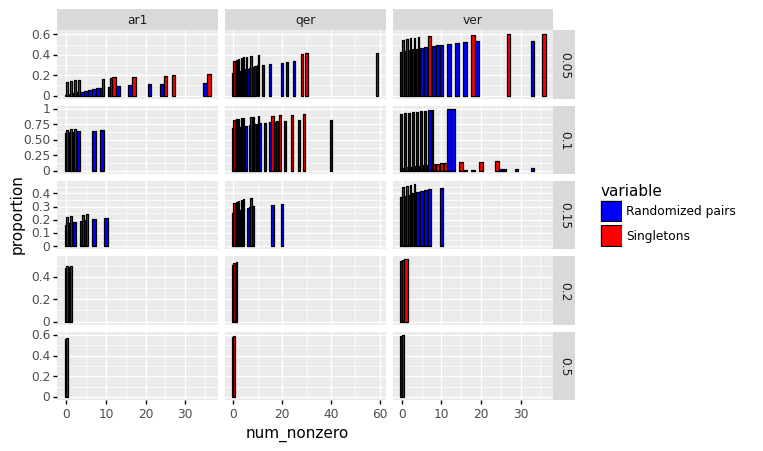

<ggplot: (8770940203560)>

In [22]:
cdata['strkappa'] = np.around(cdata['kappa'], 2).astype(str)
g = (
    ggplot(
        cdata, aes(x='num_nonzero', y='proportion', fill='variable')
    )
    + geom_col(position='dodge', color='black')
    + facet_grid("strkappa~covmethod", scales='free')
    + scale_fill_manual(['blue','red'])
)
g